In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Bidirectional
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#import chart_studio.plotly as py
#import plotly.offline as pyoff
#import plotly.graph_objs as go
#pyoff.init_notebook_mode()

In [2]:
data = pd.read_csv("Gift_Shops_MCC.csv", encoding="ISO-8859-1")

In [3]:
data.head()

PARTY_ID TRANS_TYPE_ECOM_POS_ATM  \
0  100000006022917                     POS   
1  100000003112786                     POS   
2  100000003112786                     POS   
3  100000003112786                     POS   
4  100000000718541                     POS   

                           MCC_High_level         Merchant Name  Year  Month  \
0  Gift, Card, Novelty and Souvenir Shops      DERAH TRADING CO  2022     10   
1  Gift, Card, Novelty and Souvenir Shops  BASTAT ALTAWFEER EST  2022      1   
2  Gift, Card, Novelty and Souvenir Shops  BASTAT ALTAWFEER EST  2022      6   
3  Gift, Card, Novelty and Souvenir Shops  BASTAT ALTAWFEER EST  2022      3   
4  Gift, Card, Novelty and Souvenir Shops   Hala Al Otaibi Trad  2022      7   

   Day  Daily_Sum_Debit_Card_TRANSACTION_AMOUNT  \
0    9                                      NaN   
1    4                                      NaN   
2   20                                      NaN   
3    5                                      NaN   
4    1                                      NaN   

   Daily_Count_Debit_Card_TRANSACTION_AMOUNT  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   Daily_Avg_Debit_Card_TRANSACTION_AMOUNT  ...  \
0                                      NaN  ...   
1                                      NaN  ...   
2                                      NaN  ...   
3                                      NaN  ...   
4                                      NaN  ...   

   Monthly_Avg_Debit_Card_TRANSACTION_AMOUNT  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   Monthly_Sum_Credit_Card_TRANSACTION_AMOUNT  \
0                                      120.00   
1                                       80.00   
2                                      368.00   
3                                      396.75   
4                                       15.00   

   Monthly_Count_Credit_Card_TRANSACTION_AMOUNT  \
0                                             1   
1                                             1   
2                                             1   
3                                             1   
4                                             1   

   Monthly_Avg_Credit_Card_TRANSACTION_AMOUNT  \
0                                      120.00   
1                                       80.00   
2                                      368.00   
3                                      396.75   
4                                       15.00   

  Yearly_Sum_Debit_Card_TRANSACTION_AMOUNT  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  Yearly_Count_Debit_Card_TRANSACTION_AMOUNT  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

  Yearly_Avg_Debit_Card_TRANSACTION_AMOUNT  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  Yearly_Sum_Credit_Card_TRANSACTION_AMOUNT  \
0                                    120.00   
1                                    844.75   
2                                    844.75   
3                                    844.75   
4                                     15.00   

  Yearly_Count_Credit_Card_TRANSACTIO

In [4]:
#data=data[(data['Year']==2014)|(data['Year']==2015)|(data['Year']==2016)]Daily_Sum_Debit_Card_TRANSACTION_AMOUNT

In [5]:
data ['Date'] = pd.to_datetime(dict (year=data.Year, month=data.Month, day=data.Day))
data=data[['Date','MCC_High_level','Daily_Sum_Debit_Card_TRANSACTION_AMOUNT','Daily_Sum_Credit_Card_TRANSACTION_AMOUNT']]
data.head()

Date                          MCC_High_level  \
0 2022-10-09  Gift, Card, Novelty and Souvenir Shops   
1 2022-01-04  Gift, Card, Novelty and Souvenir Shops   
2 2022-06-20  Gift, Card, Novelty and Souvenir Shops   
3 2022-03-05  Gift, Card, Novelty and Souvenir Shops   
4 2022-07-01  Gift, Card, Novelty and Souvenir Shops   

   Daily_Sum_Debit_Card_TRANSACTION_AMOUNT  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   Daily_Sum_Credit_Card_TRANSACTION_AMOUNT  
0                                    120.00  
1                                     80.00  
2                                    368.00  
3                                    396.75  
4                                     15.00

In [6]:
data["Daily_Sum_Debit_Card_TRANSACTION_AMOUNT"]=data["Daily_Sum_Debit_Card_TRANSACTION_AMOUNT"].fillna(0)
data["Daily_Sum_Credit_Card_TRANSACTION_AMOUNT"]=data["Daily_Sum_Credit_Card_TRANSACTION_AMOUNT"].fillna(0)
data['Total Sales']=data["Daily_Sum_Credit_Card_TRANSACTION_AMOUNT"]+data["Daily_Sum_Debit_Card_TRANSACTION_AMOUNT"]
data.drop(['Daily_Sum_Debit_Card_TRANSACTION_AMOUNT','Daily_Sum_Credit_Card_TRANSACTION_AMOUNT'],axis=1,inplace=True)
data = data.set_index('Date')
data.head()

MCC_High_level  Total Sales
Date                                                           
2022-10-09  Gift, Card, Novelty and Souvenir Shops       120.00
2022-01-04  Gift, Card, Novelty and Souvenir Shops        80.00
2022-06-20  Gift, Card, Novelty and Souvenir Shops       368.00
2022-03-05  Gift, Card, Novelty and Souvenir Shops       396.75
2022-07-01  Gift, Card, Novelty and Souvenir Shops        15.00

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748277 entries, 2022-10-09 to 2023-01-18
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   MCC_High_level  748277 non-null  object 
 1   Total Sales     748277 non-null  float64
dtypes: float64(1), object(1)
memory usage: 17.1+ MB


In [8]:
"""
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 10))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Groceries and Supermarkets Time Series Plot")
plt.plot(data[data['MCC_High_level']=="Groceries and Supermarkets"]["Total Sales"])
"""

'\nplt.style.use("fivethirtyeight")\nplt.figure(figsize=(15, 10))\nplt.xlabel("Date")\nplt.ylabel("Sales")\nplt.title("Groceries and Supermarkets Time Series Plot")\nplt.plot(data[data[\'MCC_High_level\']=="Groceries and Supermarkets"]["Total Sales"])\n'

In [9]:
data.to_period("D").head()

MCC_High_level  Total Sales
Date                                                           
2022-10-09  Gift, Card, Novelty and Souvenir Shops       120.00
2022-01-04  Gift, Card, Novelty and Souvenir Shops        80.00
2022-06-20  Gift, Card, Novelty and Souvenir Shops       368.00
2022-03-05  Gift, Card, Novelty and Souvenir Shops       396.75
2022-07-01  Gift, Card, Novelty and Souvenir Shops        15.00

In [10]:
"""
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 10))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Groceries and Supermarkets Time Series Plot")
plt.plot(data[data['MCC_High_level']=="Groceries and Supermarkets"]["Total Sales"])
"""

'\nplt.style.use("fivethirtyeight")\nplt.figure(figsize=(15, 10))\nplt.xlabel("Date")\nplt.ylabel("Sales")\nplt.title("Groceries and Supermarkets Time Series Plot")\nplt.plot(data[data[\'MCC_High_level\']=="Groceries and Supermarkets"]["Total Sales"])\n'

In [11]:
data=data.sort_values('Date')
data['Total Sales']=data['Total Sales'].interpolate(option='spline')
data.head()

MCC_High_level  Total Sales
Date                                                           
2022-01-01  Gift, Card, Novelty and Souvenir Shops        44.00
2022-01-01  Gift, Card, Novelty and Souvenir Shops        58.00
2022-01-01  Gift, Card, Novelty and Souvenir Shops        90.00
2022-01-01  Gift, Card, Novelty and Souvenir Shops        23.00
2022-01-01  Gift, Card, Novelty and Souvenir Shops        17.25

In [12]:
"""
dec=seasonal_decompose(data['Total Sales'], model='multiplicable', period=6)
dec.plot()
"""

"\ndec=seasonal_decompose(data['Total Sales'], model='multiplicable', period=6)\ndec.plot()\n"

In [13]:
"""
# Run Dicky-Fuller test
adtest = adfuller(data['Total Sales'])
# Print test statistic
print(adtest[0])
# Print p-value
print(adtest[1])
"""

"\n# Run Dicky-Fuller test\nadtest = adfuller(data['Total Sales'])\n# Print test statistic\nprint(adtest[0])\n# Print p-value\nprint(adtest[1])\n"

In [14]:
data['Week']=data.index.strftime("%U")
data['Week']=data['Week'].astype('str')+data.index.year.astype('str')
data.set_index(['Week', 'MCC_High_level'], inplace=True)
data.head()

Total Sales
Week   MCC_High_level                                     
002022 Gift, Card, Novelty and Souvenir Shops        44.00
       Gift, Card, Novelty and Souvenir Shops        58.00
       Gift, Card, Novelty and Souvenir Shops        90.00
       Gift, Card, Novelty and Souvenir Shops        23.00
       Gift, Card, Novelty and Souvenir Shops        17.25

In [15]:
data.groupby(['MCC_High_level','Week'])['Total Sales'].transform('sum').duplicated().sort_values().head(100)

Week    MCC_High_level                        
002022  Gift, Card, Novelty and Souvenir Shops    False
442022  Gift, Card, Novelty and Souvenir Shops    False
132022  Gift, Card, Novelty and Souvenir Shops    False
302022  Gift, Card, Novelty and Souvenir Shops    False
252022  Gift, Card, Novelty and Souvenir Shops    False
                                                  ...  
422022  Gift, Card, Novelty and Souvenir Shops     True
        Gift, Card, Novelty and Souvenir Shops     True
        Gift, Card, Novelty and Souvenir Shops     True
        Gift, Card, Novelty and Souvenir Shops     True
        Gift, Card, Novelty and Souvenir Shops     True
Name: Total Sales, Length: 100, dtype: bool

In [16]:
dataw=data.groupby(['MCC_High_level','Week'])['Total Sales'].agg('sum')
#dataw=dataw.drop_duplicates()
dataw.head(10)

MCC_High_level                          Week  
Gift, Card, Novelty and Souvenir Shops  002022     292081.30
                                        012022    1676930.12
                                        012023    1613590.49
                                        022022    1622875.95
                                        022023    1419453.21
                                        032022    1157226.38
                                        032023    1136544.51
                                        042022    2138374.86
                                        042023    1645446.13
                                        052022    1775219.10
Name: Total Sales, dtype: float64

In [17]:
del data
#dataw=hampel(dataw)

# IQR
Q1 = np.percentile(dataw, 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(dataw, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above Upper bound
upper=Q3+1.5*IQR
upper_array=np.array(dataw>=upper)
print("Upper Bound:",upper)
print(upper_array)
 
#Below Lower bound
lower=Q1-1.5*IQR
lower_array=np.array(dataw<=lower)
print("Lower Bound:",lower)
print(lower_array)

dataw=dataw[(dataw<=upper) & (dataw>=lower)]

dataw.shape

Upper Bound: 3009931.0650000004
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False  True False]
Lower Bound: 463522.9850000001
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


(60,)

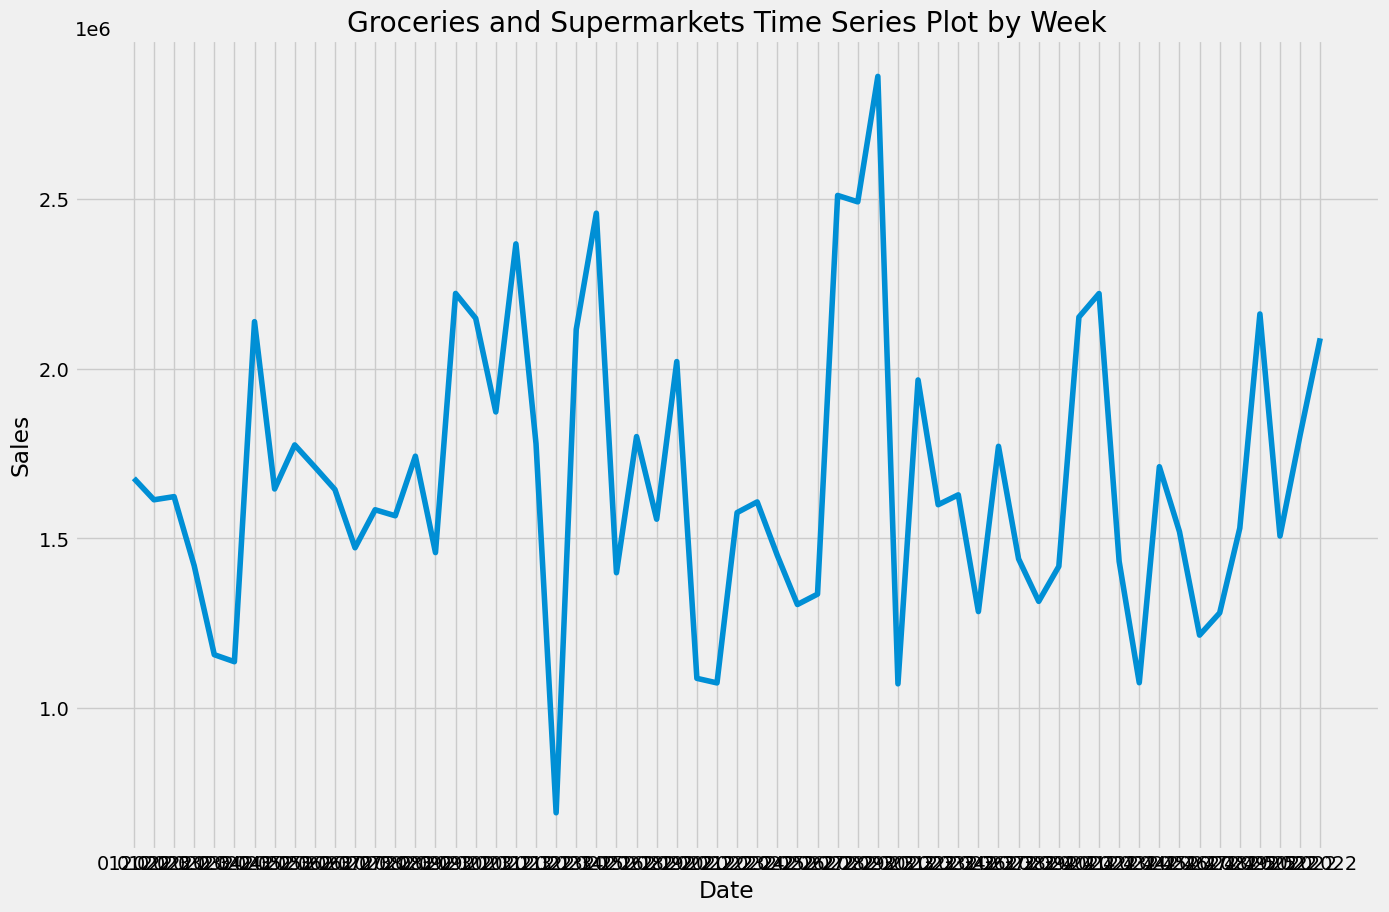

In [18]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 10))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Groceries and Supermarkets Time Series Plot by Week")
plt.plot(dataw.droplevel(0))

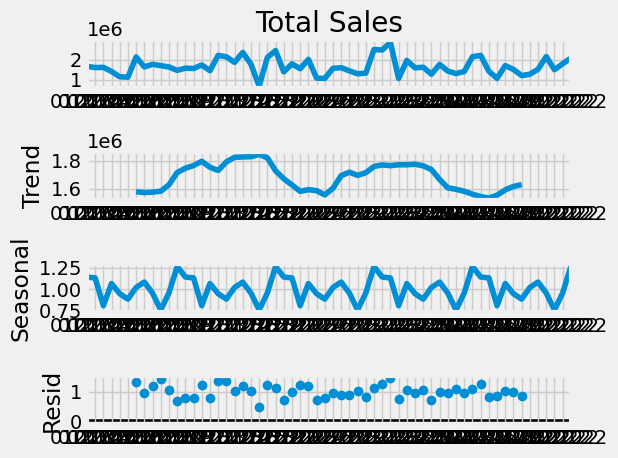

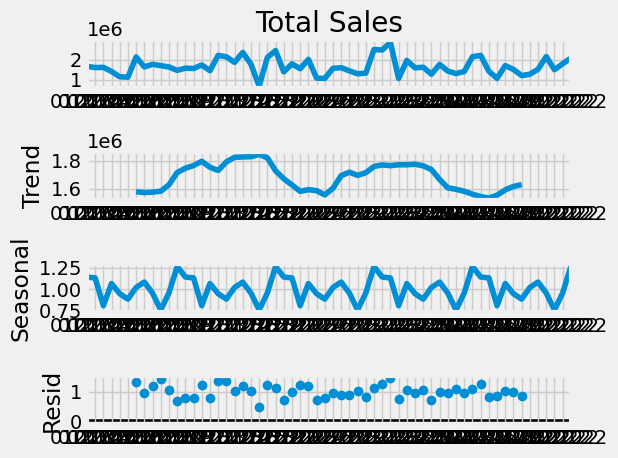

In [19]:
dec=seasonal_decompose(dataw.droplevel(0), model='multiplicable', period=12)
dec.plot()

In [20]:
# Run Dicky-Fuller test
adtest = adfuller(dataw.droplevel(0))
# Print test statistic
print(adtest[0])
# Print p-value
print(adtest[1])

-6.487765167540292
1.2484803384078192e-08


<AxesSubplot: xlabel='Week', ylabel='Total Sales'>

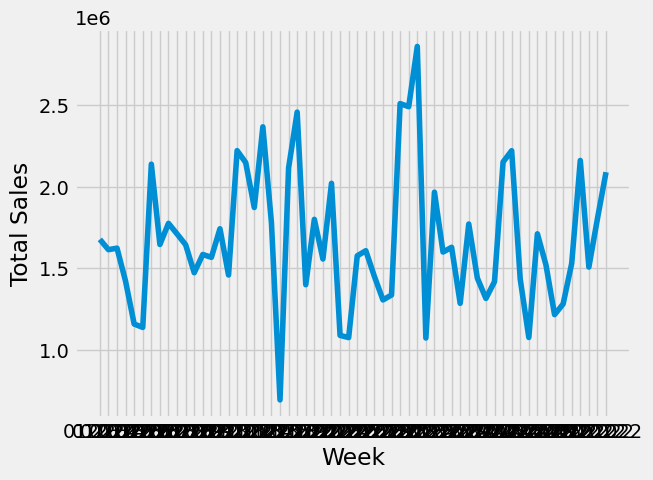

In [21]:
sns.lineplot(data=dataw.droplevel(0))

In [22]:
datawdiff=dataw.shift(3)
datawst=dataw-datawdiff
# Run Dicky-Fuller test
adtest = adfuller(datawst.dropna().droplevel(0))
# Print test statistic
print(adtest[0])
# Print p-value
print(adtest[1])

-4.412484049136417
0.0002820907070991076


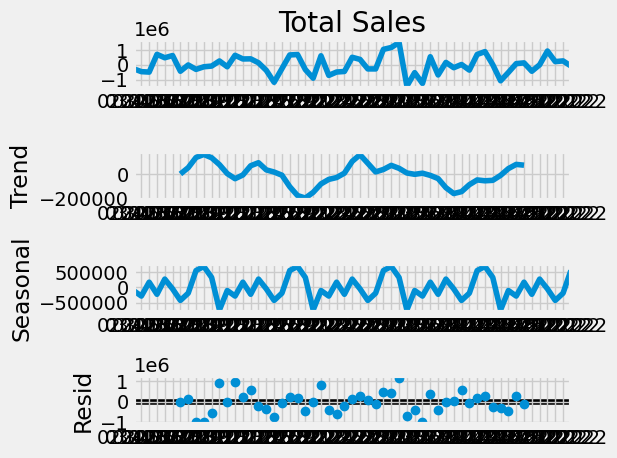

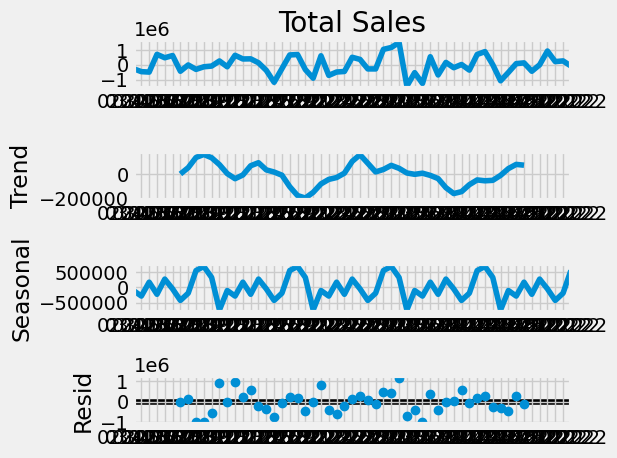

In [23]:
dec=seasonal_decompose(datawst.dropna().droplevel(0), period=12)
dec.plot()

<AxesSubplot: xlabel='Week', ylabel='Total Sales'>

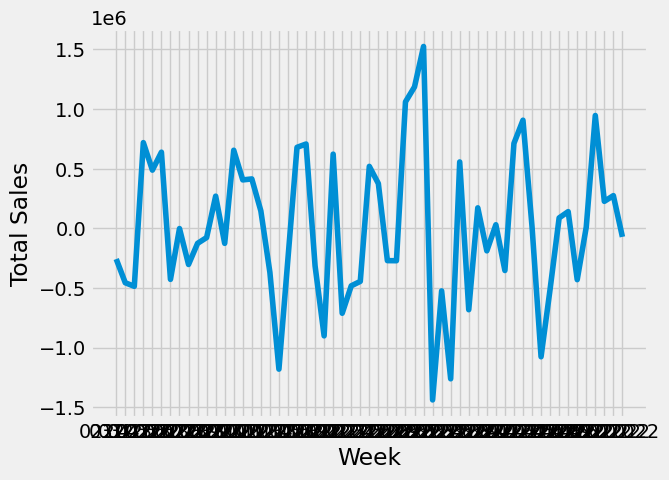

In [24]:
datawst=datawst.dropna()
sns.lineplot(data=datawst.droplevel(0))

In [25]:
dataw.shape

(60,)

In [26]:
#adding lags
df_supervised=pd.DataFrame(dataw)
df_supervised.info()
for inc in range(1,13):
    field_name='lag_'+str(inc)
    #df_supervised[field_name]=df_supervised["Total Sales"].shift(3*inc)
    df_supervised[field_name]=df_supervised["Total Sales"].shift(inc)
df_supervised=df_supervised.dropna()
#df_supervised.drop(['lag_12','lag_13','lag_14','lag_15','lag_16','lag_17'], axis=1, inplace=True)
df_supervised.head(50)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 60 entries, ('Gift, Card, Novelty and Souvenir Shops', '012022') to ('Gift, Card, Novelty and Souvenir Shops', '522022')
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Sales  60 non-null     float64
dtypes: float64(1)
memory usage: 3.4+ KB


Total Sales       lag_1  \
MCC_High_level                         Week                              
Gift, Card, Novelty and Souvenir Shops 072022   1584207.50  1472172.77   
                                       072023   1566475.62  1584207.50   
                                       082022   1742033.99  1566475.62   
                                       082023   1458012.12  1742033.99   
                                       092022   2221486.88  1458012.12   
                                       092023   2148210.89  2221486.88   
                                       102022   1872386.53  2148210.89   
                                       102023   2367578.48  1872386.53   
                                       112022   1778720.71  2367578.48   
                                       112023    691509.84  1778720.71   
                                       122022   2115362.11   691509.84   
                                       132022   2458027.83  2115362.11   
                                       142022   1398650.90  2458027.83   
                                       152022   1799813.34  1398650.90   
                                       162022   1556363.95  1799813.34   
                                       182022   2020776.75  1556363.95   
                                       192022   1087556.02  2020776.75   
                                       202022   1074044.31  1087556.02   
                                       212022   1575858.66  1074044.31   
                                       222022   1607283.33  1575858.66   
                                       232022   1449712.33  1607283.33   
                                       242022   1305034.44  1449712.33   
                                       252022   1335643.52  1305034.44   
                                       262022   2510269.49  1335643.52   
                                       272022   2491339.77  2510269.49   
                                       282022   2860933.12  2491339.77   
                                       292022   1071398.19  2860933.12   
                                       302022   1966683.67  1071398.19   
                                       312022   1599090.96  1966683.67   
                                       322022   1628157.79  1599090.96   
                                       332022   1284229.99  1628157.79   
                                       342022   1771161.07  1284229.99   
                                       362022   1439403.46  1771161.07   
                                       372022   1314310.13  1439403.46   
                                       382022   1417398.82  1314310.13   
                                       392022   2151808.48  1417398.82   
                                       402022   2221179.58  2151808.48   
                                       412022   1432191.18  2221179.58   
                                       422022   1074634.32  1432191.18   
                                       432022   1711006.82  1074634.32   
                                       442022   1519694.47  1711006.82   
                                       452022   1214815.88  1519694.47   
                                       462022   1280432.99  1214815.88   
                                       472022   1530101.23  1280432.99   
                                       482022   2160996.98  1530101.23   
                                       492022   1506731.33  2160996.98   
                                       502022   1804397.58  1506731.33   
                                       522022   2089279.32  1804397.58   

                                                    lag_2       lag_3  \
MCC_High_level                         Week                             
Gift, Card, Novelty and Souvenir Shops 072022  1643709.81  1710193.76   
                                       072023  1472172.77  1643709.81   
                                       082022  1584207

In [27]:
df_supervised.shape

(48, 13)

In [28]:
df_supervised.rename(columns={"Total Sales": "TotalSales"}, inplace=True)
model = smf.ols(formula='TotalSales ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)
model_fit=model.fit()
print(model_fit.rsquared_adj)

-0.12713795741968847


In [29]:
df_model = df_supervised.reset_index(drop=True)
train, test = df_model[0:-5].values, df_model[-5:].values

In [30]:
np.shape(train),np.shape(test)

((43, 13), (5, 13))

In [31]:
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(train)
train=train.reshape(train.shape[0],train.shape[1])
train_scaled=scaler.transform(train)
test=test.reshape(test.shape[0],test.shape[1])
test_scaled=scaler.transform(test)

In [32]:
trainx,trainy=train_scaled[:, 1:],train_scaled[:, 0:1]
trainx=trainx.reshape(trainx.shape[0],1,trainx.shape[1])
testx,testy=test_scaled[:, 1:],test_scaled[:, 0:1]
testx=testx.reshape(testx.shape[0],1,testx.shape[1])

In [33]:
np.shape(train),np.shape(test)

((43, 13), (5, 13))

In [54]:
callback = EarlyStopping(monitor='loss', patience=50)
model=Sequential()
#model.add(GRU(16,batch_input_shape=(1,trainx.shape[1],trainx.shape[2]),stateful=False))
model.add(LSTM(64,batch_input_shape=(1,trainx.shape[1],trainx.shape[2]),stateful=False))
#model.add(layers.Bidirectional(layers.LSTM(128,batch_input_shape=(1,trainx.shape[1],trainx.shape[2]),stateful=False)))
model.add(Dropout(0.25))
model.add(Dense(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainx, trainy, epochs=500, batch_size=1, verbose=1, shuffle=False, callbacks=[callback])

Epoch 1/500
43/43 [==============================] - 1s 1ms/step - loss: 0.1944
Epoch 2/500
43/43 [==============================] - 0s 875us/step - loss: 0.1789
Epoch 3/500
43/43 [==============================] - 0s 618us/step - loss: 0.1760
Epoch 4/500
43/43 [==============================] - 0s 946us/step - loss: 0.1662
Epoch 5/500
43/43 [==============================] - 0s 920us/step - loss: 0.1703
Epoch 6/500
43/43 [==============================] - 0s 923us/step - loss: 0.1589
Epoch 7/500
43/43 [==============================] - 0s 762us/step - loss: 0.1618
Epoch 8/500
43/43 [==============================] - 0s 1ms/step - loss: 0.1552
Epoch 9/500
43/43 [==============================] - 0s 982us/step - loss: 0.1555
Epoch 10/500
43/43 [==============================] - 0s 809us/step - loss: 0.1511
Epoch 11/500
43/43 [==============================] - 0s 1ms/step - loss: 0.1493
Epoch 12/500
43/43 [==============================] - 0s 875us/step - loss: 0.1429
Epoch 13/500
43/43 

In [55]:
ypred=model.predict(testx, batch_size=1)
ypred

5/5 [==============================] - 0s 1ms/step


array([[-0.1814581 ],
       [ 0.27852893],
       [ 0.40799034],
       [-0.02981896],
       [ 0.08293486]], dtype=float32)

In [56]:
ypred = ypred.reshape(ypred.shape[0], 1, ypred.shape[1])
testpred=[]
for idx in range(0, len(ypred)):
    print(np.concatenate([ypred[idx], testx[idx]],axis=1))
    testpred.append(np.concatenate([ypred[idx], testx[idx]],axis=1))
print('--------------------------------------------')
testpred=np.array(testpred)
testpred=testpred.reshape(testpred.shape[0], testpred.shape[2])

testpred_inverted=scaler.inverse_transform(testpred)
print(testpred_inverted)

[[-0.1814581  -0.45706939 -0.51756207 -0.23649328 -0.06012166 -0.64679601
  -0.31716291  0.41020865  0.34625516 -0.33080005 -0.42583792 -0.31051388
  -0.00466521]]
[[ 0.27852893 -0.22689924 -0.45706939 -0.51756207 -0.23649328 -0.06012166
  -0.64679601 -0.31716291  0.41020865  0.34625516 -0.33080005 -0.42583792
  -0.31051388]]
[[ 0.40799034  0.35472607 -0.22689924 -0.45706939 -0.51756207 -0.23649328
  -0.06012166 -0.64679601 -0.31716291  0.41020865  0.34625516 -0.33080005
  -0.42583792]]
[[-0.02981896 -0.24844405  0.35472607 -0.22689924 -0.45706939 -0.51756207
  -0.23649328 -0.06012166 -0.64679601 -0.31716291  0.41020865  0.34625516
  -0.33080005]]
[[ 0.08293486  0.02597566 -0.24844405  0.35472607 -0.22689924 -0.45706939
  -0.51756207 -0.23649328 -0.06012166 -0.64679601 -0.31716291  0.41020865
   0.34625516]]
--------------------------------------------
[[1579391.76602387 1280432.99       1214815.88       1519694.47
  1711006.82       1074634.32       1432191.18       2221179.58
  21518

In [57]:
result_list=[]
dates=list(pd.DataFrame(dataw)[-5:].droplevel(0).index)
print('dates: '+str(dates))
sales=list(pd.DataFrame(dataw)[-5:].values)
print('sales: '+str(sales))

for idx in range(len(testpred_inverted)):
    res_dict={}
    res_dict['value_pred']=int(testpred_inverted[idx][0]+sales[idx])
    res_dict['week']=dates[idx]
    result_list.append(res_dict)
result_df=pd.DataFrame(result_list)
print(result_df)

dates: ['472022', '482022', '492022', '502022', '522022']
sales: [array([1530101.23]), array([2160996.98]), array([1506731.33]), array([1804397.58]), array([2089279.32])]
   value_pred    week
0     3109492  472022
1     4239342  482022
2     3725504  492022
3     3548274  502022
4     3955461  522022


In [58]:
sales_df=pd.DataFrame({'week':dataw.droplevel(0).index, 'sales':dataw})[-5:]
sales_pred_df=pd.merge(sales_df,result_df, on='week',how='left')
sales_pred_df

week       sales  value_pred
0  472022  1530101.23     3109492
1  482022  2160996.98     4239342
2  492022  1506731.33     3725504
3  502022  1804397.58     3548274
4  522022  2089279.32     3955461

In [59]:
mse = np.square(np.subtract(sales_pred_df['sales'],sales_pred_df['value_pred']-2000000)).mean()
mse

62883635731.712204

In [60]:
pdf=pd.DataFrame({'week':dataw.droplevel(0).index, 'sales':dataw})
pdf=pd.merge(pdf,result_df, on='week',how='left')
pdf

week       sales  value_pred
0   012022  1676930.12         NaN
1   012023  1613590.49         NaN
2   022022  1622875.95         NaN
3   022023  1419453.21         NaN
4   032022  1157226.38         NaN
5   032023  1136544.51         NaN
6   042022  2138374.86         NaN
7   042023  1645446.13         NaN
8   052022  1775219.10         NaN
9   052023  1710193.76         NaN
10  062022  1643709.81         NaN
11  062023  1472172.77         NaN
12  072022  1584207.50         NaN
13  072023  1566475.62         NaN
14  082022  1742033.99         NaN
15  082023  1458012.12         NaN
16  092022  2221486.88         NaN
17  092023  2148210.89         NaN
18  102022  1872386.53         NaN
19  102023  2367578.48         NaN
20  112022  1778720.71         NaN
21  112023   691509.84         NaN
22  122022  2115362.11         NaN
23  132022  2458027.83         NaN
24  142022  1398650.90         NaN
25  152022  1799813.34         NaN
26  162022  1556363.95         NaN
27  182022  2020776.75         NaN
28  192022  1087556.02         NaN
29  202022  1074044.31         NaN
30  212022  1575858.66         NaN
31  222022  1607283.33         NaN
32  232022  1449712.33         NaN
33  242022  1305034.44         NaN
34  252022  1335643.52         NaN
35  262022  2510269.49         NaN
36  272022  2491339.77         NaN
37  282022  2860933.12         NaN
38  292022  1071398.19         NaN
39  302022  1966683.67         NaN
40  312022  1599090.96         NaN
41  322022  1628157.79         NaN
42  332022  1284229.99         NaN
43  342022  1771161.07         NaN
44  362022  1439403.46         NaN
45  372022  1314310.13         NaN
46  382022  1417398.82         NaN
47  392022  2151808.48         NaN
48  402022  2221179.58         NaN
49  412022  1432191.18         NaN
50  422022  1074634.32         NaN
51  432022  1711006.82         NaN
52  442022  1519694.47         NaN
53  452022  1214815.88         NaN
54  462022  1280432.99         NaN
55  472022  1530101.23   3109492.0
56  482022  2160996.98   4239342.0
57  492022  1506731.33   3725504.0
58  502022  1804397.58   3548274.0
59  522022  2089279.32   3955461.0

<AxesSubplot: ylabel='sales'>

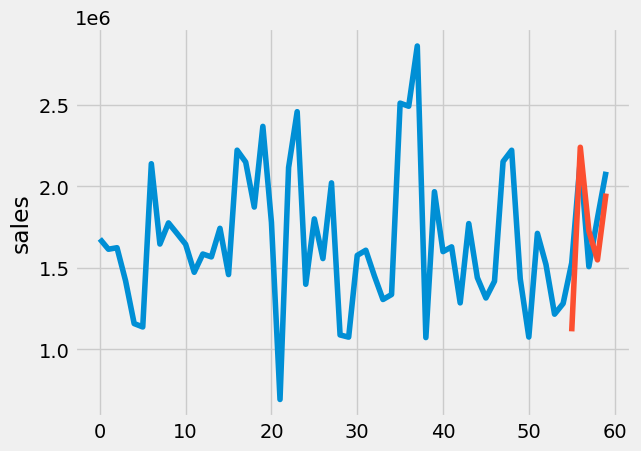

In [61]:
sns.lineplot(data=pdf['sales'])
sns.lineplot(data=pdf['value_pred']-2000000)

In [70]:
num_units=[16,32,64,128]
drop_prob=[0.1,0.15,0.2,0.25,0.3]
dense_size=[50,100,200,400,800,1000]
mse = np.square(np.subtract(sales_pred_df['sales'],sales_pred_df['value_pred']-2000000)).mean()
best_num_units=None
best_drop_prob=None
best_dense_size=None
best_model=None
error=float("inf")

for n in num_units:
    for p in drop_prob:
        for d in dense_size:
            callback = EarlyStopping(monitor='loss', patience=50)
            model=Sequential()
            model.add(LSTM(n,batch_input_shape=(1,trainx.shape[1],trainx.shape[2]),stateful=False))
            model.add(Dropout(p))
            model.add(Dense(d))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')
            model.fit(trainx, trainy, epochs=500, batch_size=1, verbose=1, shuffle=False, callbacks=[callback])
            ypred=model.predict(testx, batch_size=1)
            
            ypred = ypred.reshape(ypred.shape[0], 1, ypred.shape[1])
            testpred=[]
            for idx in range(0, len(ypred)):
                testpred.append(np.concatenate([ypred[idx], testx[idx]],axis=1))
            testpred=np.array(testpred)
            testpred=testpred.reshape(testpred.shape[0], testpred.shape[2])
            testpred_inverted=scaler.inverse_transform(testpred)
            #print(testpred_inverted)
            sales_df=pd.DataFrame({'week':dataw.droplevel(0).index, 'sales':dataw})[-5:]
            mse = np.square(np.subtract(sales_pred_df['sales'].iloc[-5],testpred_inverted[0]-2000000)).mean()
            if mse<error:
                error=mse
                best_num_units=n
                best_drop_prob=p
                best_dense_size=d
                best_model=model

            

Epoch 1/500
43/43 [==============================] - 1s 868us/step - loss: 0.1872
Epoch 2/500
43/43 [==============================] - 0s 945us/step - loss: 0.1783
Epoch 3/500
43/43 [==============================] - 0s 465us/step - loss: 0.1737
Epoch 4/500
43/43 [==============================] - 0s 718us/step - loss: 0.1716
Epoch 5/500
43/43 [==============================] - 0s 1ms/step - loss: 0.1655
Epoch 6/500
43/43 [==============================] - 0s 897us/step - loss: 0.1613
Epoch 7/500
43/43 [==============================] - 0s 512us/step - loss: 0.1622
Epoch 8/500
43/43 [==============================] - 0s 737us/step - loss: 0.1624
Epoch 9/500
43/43 [==============================] - 0s 1ms/step - loss: 0.1509
Epoch 10/500
43/43 [==============================] - 0s 895us/step - loss: 0.1564
Epoch 11/500
43/43 [==============================] - 0s 571us/step - loss: 0.1541
Epoch 12/500
43/43 [==============================] - 0s 1ms/step - loss: 0.1482
Epoch 13/500
43/43 